# Exploration 3
# 프로젝트: 카메라 스티커앱 만들기 첫걸음

## 1. 이미지 불러오기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

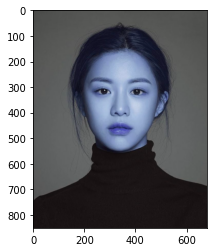

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/goyounjung_image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

opencv의 특징 때문이다. 
matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용한다.
opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용한다
그래서 내 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력된 것이다.

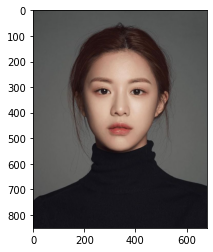

In [3]:
# 색상 이미지로 전환 BRG → RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출

rectangles[[(170, 241) (491, 562)]]


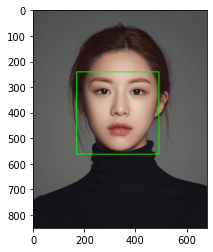

In [4]:
detector_hog = dlib.get_frontal_face_detector() # detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 얼굴 랜드마크

- Face Landmark Localization 기술을 사용해 보기
- face landmark는 detection의 결과물인 bounding box로 crop한 이미지를 이용한다

Object Keypoint Estimation

- top-down: bounding box를 찾고 box 내부의 keypoint를 예측
- bottom-up: 이미지 전체의 keypoint를 먼저 찾고, point 관계로 군집화해서 box 생성

Dlib landmark localization
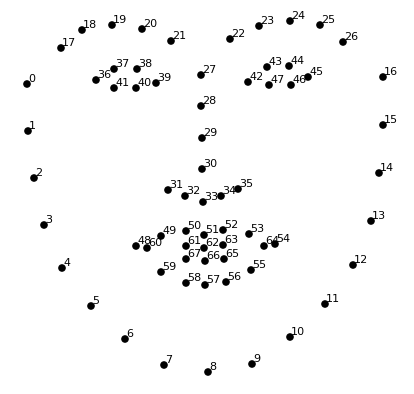

잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾는다.

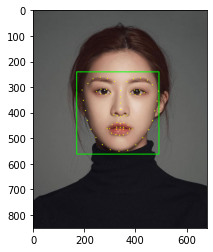

In [5]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해두기
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 스티커 적용하기
#### 스티커의 위치와 크기를 구하는 방법
- 스티커 위치
x = x(nose)
y = y(nose) - width/2
- 스티커 크기
width = height = width(bbox)

In [6]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))  #스티커의 위치(x, y)와 크기(w, h)를 출력
    print ('(w,h) : (%d,%d)'%(w,h))

(342, 388)
(x,y) : (342,388)
(w,h) : (322,322)


(322, 322, 3)


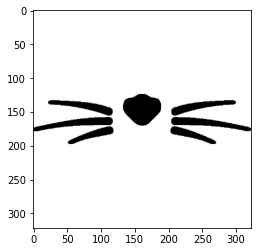

In [7]:
#스티커 불러오기
#스티커의 이미지를 읽어온 후, 위에서 계산한 크기(w, h)를 이용하여 스티커를 resize하기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

In [8]:
refined_x = x - w // 2
refined_y = y - w // 2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (181,227)


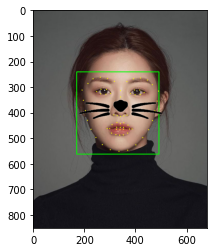

In [9]:
#원본 이미지에 스티커 적용 후 결과 출력
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

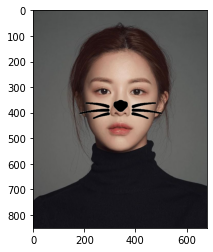

In [10]:
#box와 landmark를 제거한 후, 원본 이미지에 스티커 적용 후 최종 결과 출력
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 얼굴 각도가 틀어진 이미지

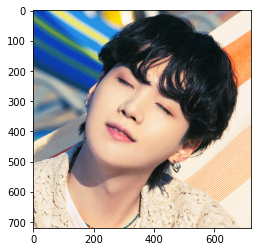

rectangles[[(170, 170) (491, 491)]]


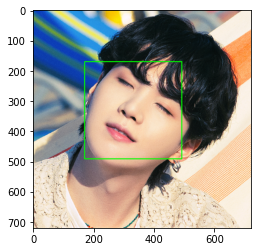

In [11]:
# 원본 이미지 불러오기
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/suga_image.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (720, 720))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)

# 얼굴에 box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

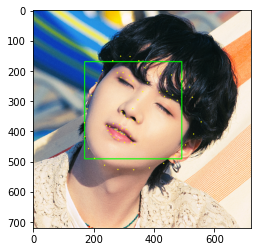

In [12]:
# landmark 모델 불러오기
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

degree:  -40.19204603696953
(312, 358)
(x, y): (151, 174)
(w, h): (322, 322)


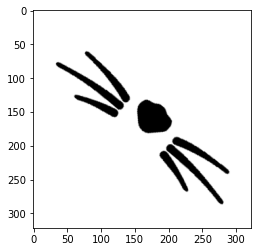

(x, y): (151, 174)


In [13]:
# 얼굴 틀어진 각도 계산
import math

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x_tilt = abs(landmark[42][0] - landmark[45][0])
    y_tilt = abs(landmark[42][1] - landmark[41][1])
    z_tilt = math.sqrt(x_tilt ** 2 + y_tilt ** 2)
    degree_tilt = -math.degrees(math.acos(x_tilt / z_tilt))
    
    print('degree: ', degree_tilt)

# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33])
    x = landmark[33][0] - dlib_rect.width() // 2
    y = landmark[31][1] - dlib_rect.width() // 2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x, y): (%d, %d)'%(x, y))
    print('(w, h): (%d, %d)'%(w, h))

# 스티커 이미지를 읽어와서 resize하기
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

tilt = cv2.getRotationMatrix2D((x, y), degree_tilt, 1)
tilt_sticker = cv2.warpAffine(img_sticker, tilt, (w, h), borderValue=(255,255,255))
tilt_sticker = cv2.resize(tilt_sticker, (w, h))

plt.imshow(tilt_sticker)
plt.show()

refined_x = x 
refined_y = y 
print('(x, y): (%d, %d)'%(refined_x, refined_y))

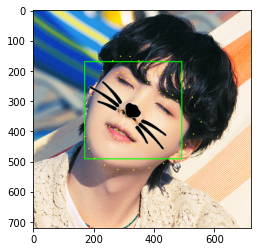

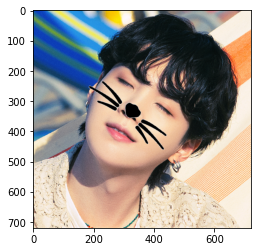

In [14]:
# 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(tilt_sticker==255, sticker_area,tilt_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(tilt_sticker==255, sticker_area,tilt_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 생각보다 얼굴 틀어진 각도와 스티커 위치를 계산해서 하려니 힘들었다.

## 촬영거리에 따라 달라지는 이미지

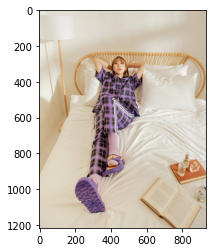

In [15]:
# 원본 이미지 불러오기
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/youngji_image.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (932,1217))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

# 얼굴 box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# landmark 모델 불러오기
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

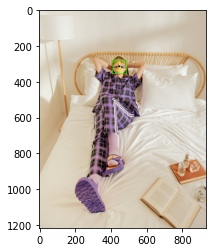

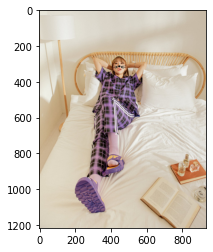

In [16]:
# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[33][0]  #얼굴에 맞게 스티커 위치 33으로 설정
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    
# 스티커 이미지를 읽어와서 resize하기
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

refined_x = x - w // 2
refined_y = y - w // 2

# 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 인물과의 거리가 있어서 랜드마크가 잘 형성될지 고민했는데.. 다행히 성공

## 선글라스 쓴 이미지

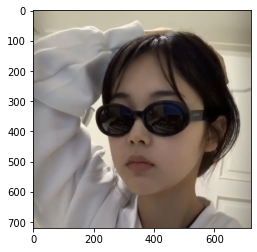

In [17]:
# 원본 이미지 불러오기
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/meenoi_image.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (720,720))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

# 얼굴 box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# landmark 모델 불러오기
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

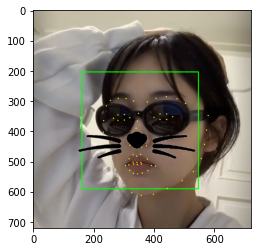

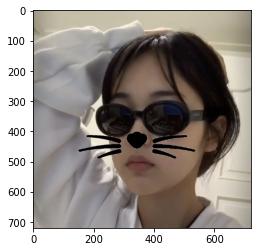

In [18]:
# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[33][0]
    y = landmark[31][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    
# 스티커 이미지를 읽어와서 resize하기
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

refined_x = x - w // 2
refined_y = y - w // 2

# 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 선글라스를 착용하고 있어서 눈이 잘 안보이는데도 랜드마크 형성이 잘되었다.

## 옆으로 누워있는 이미지

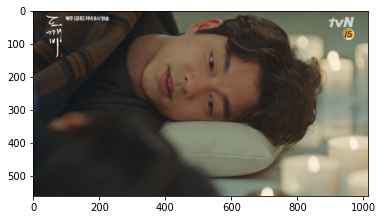

In [19]:
import cv2 as cv
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/gongyoo_image.png'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (1014,561))

img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
img_show = img_bgr.copy()

plt.imshow(img_rgb)
plt.show()

rectangles[]


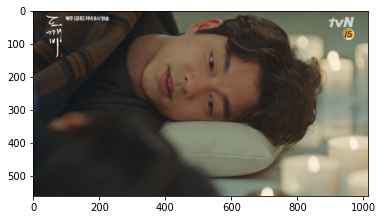

In [20]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   

# 얼굴 영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 옆으로 누워있는 사진은 인식이 잘 되지 않는다.

#### why?

아마 detector를 구현하는 코드가 정면을 기준으로 설정해두어서 그런 것 같다...

# 정리
이번 프로젝트를 하면서 체온 체크 기기가 정말 대단하다는 걸 알았다...ㅎㅎ
특히 요즘에는 마스크를 쓰고 체온 체크 기기 앞에 서있는데도 빠르게 사람들의 체온을 체크해 준다.
그런면에서 앞으로 조금 더 다양한 데이터를 가지고 해보고 싶다.
#### 아쉬운 점
이번에는 사진으로만 데스트를 해보았는데 다음에는 동영상으로 해봐야겠다.
